## Apple Product Sentiment Analysis

### by Monica Pecha, Sam Choe, and Daniel Fox

### Overview

This project analyzes--

### Business Understanding

### Data Limitations

### Table of Contents

### Exploratory Data Analysis (EDA)

In [ ]:
# Bringing in packages for EDA, pre-processing, modeling, and visualizations
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, recall_score
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Reading in the original dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding="ISO-8859-1")

In [ ]:
df.head(20)

In [ ]:
df.info()

In [ ]:
df["emotion_in_tweet_is_directed_at"].value_counts()

In [ ]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

In [ ]:
df["tweet_text"].iloc[4]

In [ ]:
# Defining keywords to diferentiate between Google and Apple product tweets
apple_keywords = ['iPad', 'IPad', 'i-Pad', 'IPAD', 'iphone', 'iPhone', 'Iphone', 'i-phone', 'I-Phone', 'Apple', 'apple', 'Ipad', 'ipad', 'iTunes','Mac', 'IPhone', 'IPHONE']
google_keywords = ['google', 'android', 'Google', 'Android', 'samsung', 'GOOGLE']

def find_brand(text):
    if isinstance(text, str):
        for word in apple_keywords:
            if word in text:
                return "Apple" 
        for word in google_keywords:
            if word in text:
                return "Google" 
    return 'No_Product'

df['product'] = df['tweet_text'].apply(find_brand)

In [ ]:
df['product'].value_counts()

In [ ]:
# Looking for null values in 'product'
df['product'].isna().sum()

In [ ]:
df['product'].head()

In [ ]:
# Converting strings to integers and combining 'neutral'/'no emotion toward brand or product' with 'unknown'/'I can't tell'
# Renaming 'is_there_an_emotion_directed_at_a_brand_or_product' to 'emotion'
mapping = {"Positive emotion": 2, "No emotion toward brand or product": 1, "I can't tell": 1, "Negative emotion": 0}
df['emotion'] = df["is_there_an_emotion_directed_at_a_brand_or_product"].map(mapping)

In [ ]:
df["emotion"].value_counts()

In [ ]:
#use 1 to show all info in cell below then comment it out and use 2 to go back to default view
#1
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#2
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_colwidth')

In [ ]:
#exploring 'No_Product' tweets
filtered_df = df[df['product'] == 'No_Product']

print(filtered_df['tweet_text'])

In [ ]:
print(df['tweet_text'][65])
print(df['tweet_text'][3079])
print(df['tweet_text'][4478])
#ill have to manually sort these

In [ ]:
#not sure about this prob nothing
print(df.iloc[7013])

In [ ]:
df2 = df[["tweet_text", "product", "emotion"]]

In [ ]:
#df2_google = df2[df2['product'] == "Google"]

In [ ]:
#df2_google.head()

In [ ]:
df2_apple = df2[df2['product'] == "Apple"]

In [ ]:
df2_apple.head()

In [ ]:
df2_apple.info()

In [ ]:
df2_apple["emotion"].value_counts(normalize=True)

#### In order to address the "emotion" class inbalance we attempted to scrape down tweets about Apple products with negative sentiment, see code and 'Forbidden' message below preventing the scraping. [Needs editing and formatting]

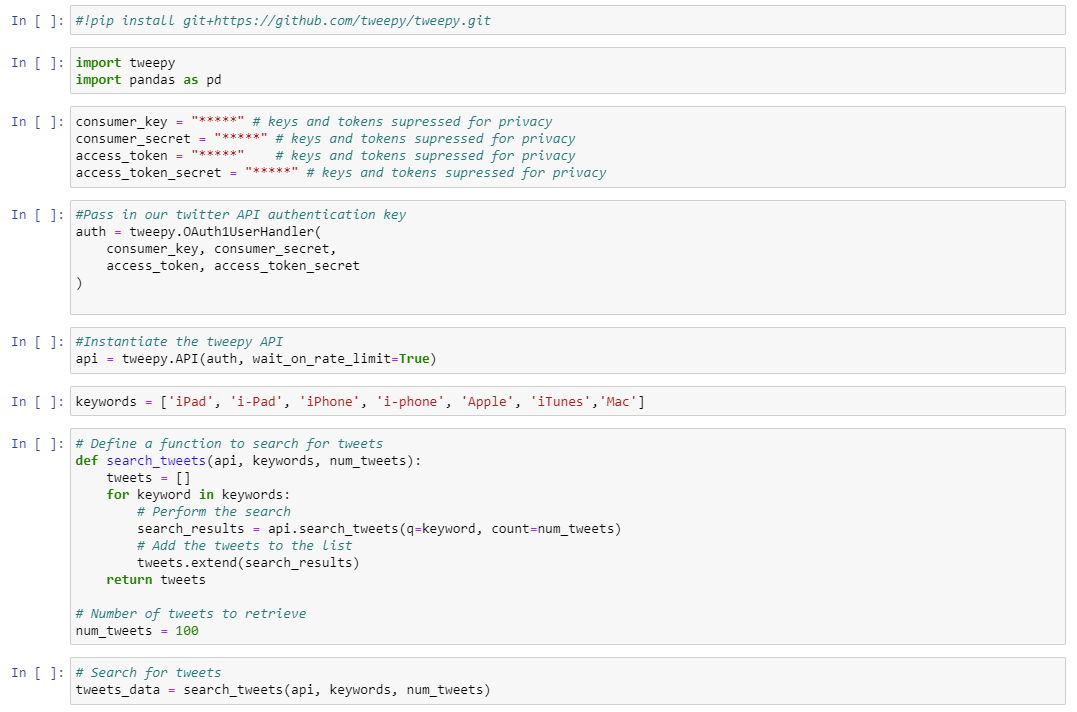

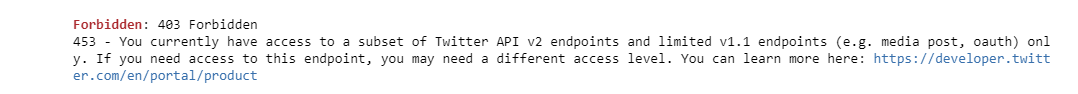

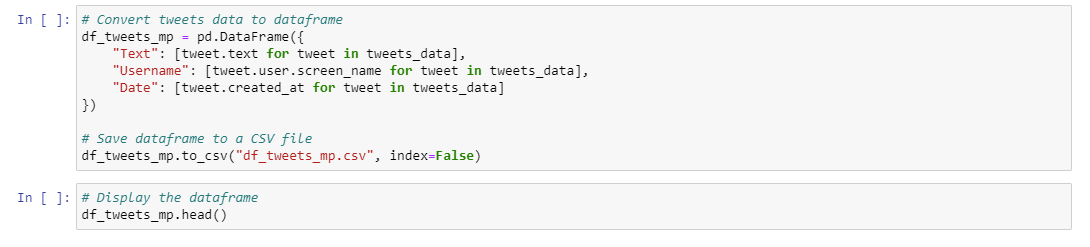

In [ ]:
df_new_tweets = pd.read_excel("data/Tweets_SyntheticGeneration_20240503.xlsx")

In [ ]:
df_new_tweets

In [ ]:
df_new_tweets.columns = ['tweet_text', 'extra_col']

In [ ]:
df_new_tweets_clean = df_new_tweets.drop_duplicates(subset='tweet_text')

In [ ]:
df_new_tweets_clean.info()

In [ ]:
df_new_tweets_clean['product'] = 'Apple'

In [ ]:
df_new_tweets_clean.head()

In [ ]:
import re # importing regular expressions

In [ ]:
# Define a regular expression pattern to match any number followed by a period and a space
pattern = r'^\d+\.\s'

In [ ]:
#Need to remove the numbers in front of the tweets
df_new_tweets_clean['tweet_text'][3]

In [ ]:
# Iterate through the dataframe column and remove the matching pattern using regex
df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))

In [ ]:
df_new_tweets_clean.head()

In [ ]:
df2_apple.head()

In [ ]:
df_combo = pd.concat([df2_apple, df_new_tweets_clean], axis=0)

In [ ]:
columns_to_drop = ['extra_col', 'emotion']
df_combo.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df_combo.info()

Implementing VADER on the emotion column

In [ ]:
#!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming df is your DataFrame with tweet texts
# Example:
# df = pd.DataFrame({'tweet_text': ["I love this place!", "This movie is terrible.", "Feeling neutral about this weather."]})

# Drop NaN values or replace with empty strings (MP-do we need this?)
df_combo['tweet_text'].fillna('', inplace=True)

# Analyze sentiment for each tweet and add the scores to the DataFrame
df_combo['sentiment'] = df_combo['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df_combo['compound_score'] = df_combo['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df_combo['emotion'] = df_combo['compound_score'].apply(categorize_sentiment)

# Print or use the DataFrame as per your requirement
print(df_combo[['tweet_text', 'compound_score', 'emotion']])

In [ ]:
df_combo.head()

In [ ]:
df_combo["emotion"].value_counts()

In [ ]:
df_combo['emotion']=df_combo['emotion'].astype(np.int64)

In [ ]:
df_combo.info()

In [ ]:
df_combo_neg_sample = df_combo[df_combo['emotion'] == 0].sample(n=1500)
df_combo_neutral_sample = df_combo[df_combo['emotion'] == 1].sample(n=1500)
df_combo_pos_sample = df_combo[df_combo['emotion'] == 2].sample(n=1500)

In [ ]:
df_combo_neg_sample.info()

In [ ]:
df_combo_neg_sample['emotion'].value_counts()

In [ ]:
df_combo_sample = pd.concat([df_combo_neg_sample, df_combo_neutral_sample, df_combo_pos_sample], axis=0)

In [ ]:
df_combo_sample.head()

In [ ]:
df_combo_sample.info()

In [ ]:
df_combo_sample['emotion'].value_counts(normalize=True)

In [ ]:
columns_to_drop = ['sentiment', 'compound_score', 'product']
df_combo_sample.drop(columns=columns_to_drop, inplace=True)

### Moving into pre processing

In [ ]:
# Defining X and y
X=df_combo_sample["tweet_text"]
y=df_combo_sample["emotion"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [ ]:
sw = stopwords.words('english')

In [ ]:
# Adding stopwords based on the dataset
sw.extend(["sxsw", "mention"])

In [ ]:
sw

In [ ]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [ ]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [ ]:
token_tweets

#### chosing count vectorizer because we are less concerned about weighting words that are unique in the corpus.

In [ ]:
X_train.head()

In [ ]:
#consider putting a pipleine here--

In [ ]:
cv=CountVectorizer()

In [ ]:
X_train_vec = cv.fit_transform(token_tweets)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [ ]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [ ]:
X_test_vec = cv.transform(token_tweets_test)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [ ]:
X_train_vec.head()

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(X_train_vec, y_train)

In [ ]:
y_pred=mnb.predict(X_test_vec)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mnb, X_test_vec, y_test )

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
precision_score(y_test, y_pred, average='weighted')

In [ ]:
recall_score(y_test, y_pred, average='weighted')

In [ ]:
from collections import Counter
import pandas as pd

# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies = X_train_vec.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(30)

# Print the most common words and their frequencies
print(most_common_words)

In [ ]:
# Extract words and their counts from most_common_words DataFrame
most_common_words = word_frequencies_df.head(30)
words = most_common_words.index
counts = most_common_words['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most Common Word Frequencies')
plt.xticks(rotation=90)
plt.show()

#### trying a TF-IDF vector instead of a count - just because. Need to change the name 'X_train_vec'? Use the same name with the count vectorizer?

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
X_train_vec = tfidf.fit_transform(token_tweets)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [ ]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [ ]:
X_test_vec = tfidf.transform(token_tweets_test)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(tfidf.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [ ]:
X_train_vec.head()

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(X_train_vec, y_train)

In [ ]:
y_pred=mnb.predict(X_test_vec)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mnb, X_test_vec, y_test )

In [ ]:
# metrics here - accurary, precision, recall

In [ ]:
grid = {'n_estimators': [500, 1000, 1500],
       'max_depth': [8, 10, 12, 14],
        'max_features': [3, 6, 9]
                }

In [ ]:
rf_clf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, max_features=3, max_depth=14)
rf.fit(X_train_vec, y_train)
y_pred = rf.predict(X_test_vec)
precision_score(y_test, y_pred, average="weighted")

In [ ]:
#create frequency distribution, other possible visuals?

Monica's notes to self

- pipeline
- rf girdsearch
- freq distributions
- other vectorizer


- combine emotion_in_tweet_is_directed_at into two options (apple and google)
- drop row 6 - missing tweet (don't need to if just focusing on Apple)
- update is_there_an_emotion_directed_at_a_brand_or_product to numeric (0=neg, 1=neutral, 2=pos)
- consider adding SWSW to stop words 
- look at @, is it dropped in punctuation. do we want it dropped?
- look at #?

- used Vader, but it did not seem to classify well after spot checking
- explored using an API to pull down additional SXSW product data

- Additional notes: Sansung and Android included with Google
- do we want to delete google specific dataframe?


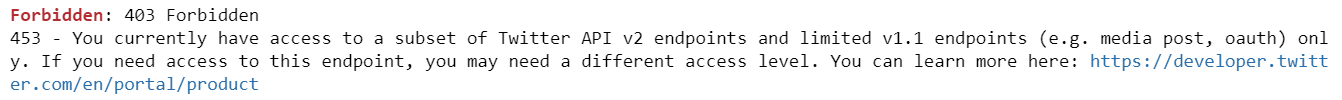
